# Классификация автомобилей по иx фотографиям с помощью нейронных сетей

**Имя на Kaggle**: Bochkareva Ksenia

**Цель**: Взять уже предобученную на ImageNet сеть Xception и дообучить под текущую задачу распознавания автомобилей на фотографиях.


**Задачи**: 
1. Провести разведочный анализ данных (EDA) предоставленного датасета (набор фотографий машин различных марок
2. Используя baseline решение текущей задачи улучшить его с помощью добавления новых методов и приемов.
3. Поэкспериментировать с методами.
4. Сделать submission на Kaggle, отформатировать код и выложить на GitHub.

**Описание датасета**:





## Подготовка к началу работы

In [1]:
# проверяем, что видеокарта подключена
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-1409a56d-da47-9b06-ee91-cba097cdd89d)


In [2]:
# Обновление tensorflow
#!pip install tensorflow --upgrade
# Загружаем обвязку под keras для использования продвинутых библиотек аугментации
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor

  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-yk5vys_g
  Running command git clone -q https://github.com/mjkvaak/ImageDataAugmentor /tmp/pip-req-build-yk5vys_g
  Created wheel for ImageDataAugmentor: filename=ImageDataAugmentor-0.0.0-cp37-none-any.whl size=29545 sha256=ea531f5cfac38efe7ff9933bb33cb4ae5e7a561bfdc0d5ae9d671bf83387fcf0
  Stored in directory: /tmp/pip-ephem-wheel-cache-r4d70q14/wheels/d9/10/55/6fca35a4072f87d694876d56ece64db3846cf45e1da1c381fe
Successfully built ImageDataAugmentor


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os
import gc

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
import tensorflow.keras.models as Model
import tensorflow.keras.layers as Layer

from sklearn.model_selection import train_test_split, StratifiedKFold

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

Python       : 3.7.11 (default, Jul  3 2021, 18:01:19) 
Numpy        : 1.19.5
Tensorflow   : 2.5.0
Keras        : 2.5.0


In [4]:
# сохраняем версии пакетов
!pip freeze > requirements.txt

## Прописываем основные настройки

In [5]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.

RANDOM_SEED          = 42

EPOCHS               = 8  # эпох на обучение
BATCH_SIZE           = 8 # уменьшаем batch если сеть большая, иначе не поместится в память на GPU
LR                   = 1e-3
VAL_SPLIT            = 0.15 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 224 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

In [6]:
#копируется весь архив со всеми файлами в директорию /content (она же - текущия директория "точка" - .)
!gsutil cp gs://oleg-zyablov/skillfactory/sf-dl-car-classification.zip .

#разархивируется общий архив, создается папка /content/sf-dl-car-classification с 4 файлами
!unzip sf-dl-car-classification.zip

#разархивируется /content/sf-dl-car-classification/train.zip в папку /content, создается папка /content/train, в ней 10 папок от 0 до 9, в них уже фото
!unzip -q -o sf-dl-car-classification/train.zip

#разархивируется /content/sf-dl-car-classification/test.zip в папку /content, создается папка /content/test_upload, в ней просто фото без меток
!unzip -q -o sf-dl-car-classification/test.zip

#прописываются пути до разархивированных папок для дальнейшего использования
sample_submission_path = '/content/sf-dl-car-classification/sample-submission.csv'
train_path = '/content/train/'
sub_path = '/content/test_upload/'


Copying gs://oleg-zyablov/skillfactory/sf-dl-car-classification.zip...
\ [1 files][  1.6 GiB/  1.6 GiB]   60.3 MiB/s                                   
Operation completed over 1 objects/1.6 GiB.                                      
Archive:  sf-dl-car-classification.zip
replace sf-dl-car-classification/sample-submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


## Разведочный анализ данных


In [7]:
#подгрузим submission
sample_submission = pd.read_csv(sample_submission_path)

Посмотрим, как выглядит тренировочный датасет:

In [8]:
train_df = pd.read_csv('/content/sf-dl-car-classification/train.csv')
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


В тренировочном датасете 15 561 наблюдение (картинки) и столько же соответствующих категорий (марка машины). В данных нет пропусков.

In [9]:
print('Количество уникальных марок автобомилей:', train_df['Category'].nunique())
train_df.Category.value_counts()

Количество уникальных марок автобомилей: 10


1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

Видим, что всего в данных 10 категорий (10 разных марок автомобилей). Данные можно считать сбалансированными - на каждую категорию приходится примено одинаковое количество картинок.

## Распределение количества картинок по категориям

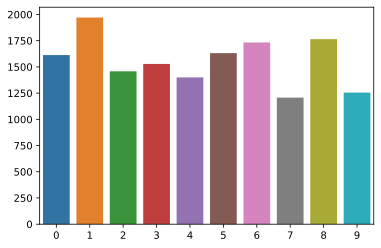

In [10]:
# Checking the frequency distribution.
sns.barplot(y=train_df.Category.value_counts().values,
            x=train_df.Category.value_counts().index);

## Посмотрим на сами картинки машин

Пример картинок


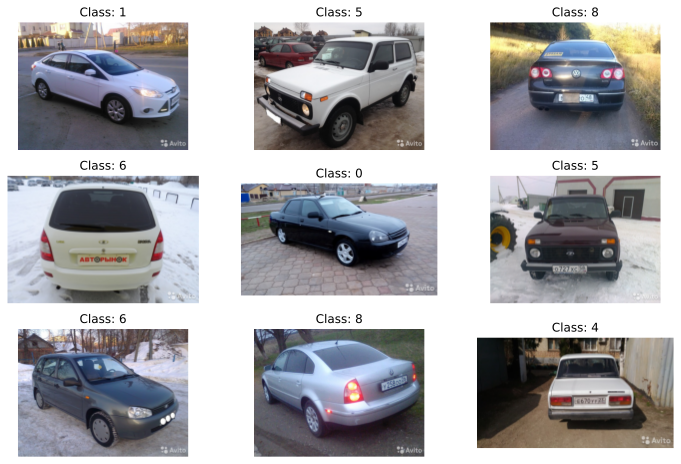

In [11]:
print('Пример картинок')
plt.figure(figsize=(12,8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(train_path+f'{random_image_cat[index]}/{path}')
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

Картинки в датасете представлены разного размера.

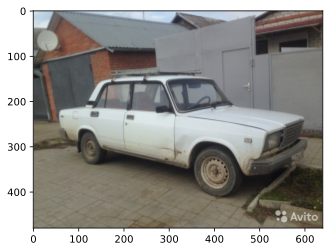

Размер картинки: (640, 480)


In [11]:
#Посмотрим на примеры картинок и их размеры, чтобы понимать, как их лучше обрабатывать и сжимать.
image = PIL.Image.open(train_path+f'/4/1065.jpg')
imgplot = plt.imshow(image)
plt.show()
print('Размер картинки:',image.size)

## Подготовка данных: аугментация

In [12]:
#устанавливаем нужную версию библиотеки
!pip install albumentations==0.5.2

In [13]:
from ImageDataAugmentor.image_data_augmentor import *
import albumentations as A

In [14]:
#параметры аугментации
AUGMENTATIONS = A.Compose([
   A.GaussianBlur(p=0.05),
   A.RandomBrightness(limit=0.2, p=0.5),
   A.ShiftScaleRotate(shift_limit=0.0625, 
                      scale_limit=0.01, 
                      interpolation=1, 
                      border_mode=4, 
                      rotate_limit=20, 
                      p=.75),
   A.OneOf([
       A.CenterCrop(height=224, width=200),
       A.CenterCrop(height=200, width=224)],
       p=0.5),
   A.OneOf([
       A.RandomBrightnessContrast(brightness_limit=0.3, 
                                               contrast_limit=0.3),
       A.RandomBrightnessContrast(brightness_limit=0.1, 
                                               contrast_limit=0.1)],
       p=0.5),
   A.HorizontalFlip(p=0.5),
   A.HueSaturationValue(p=0.5),
   A.RGBShift(p=0.5),
   A.FancyPCA(alpha=0.1, 
               always_apply=False, 
               p=0.5),
   A.Resize(IMG_SIZE, IMG_SIZE), 
])

## Генерация данных

In [15]:
train_gen = ImageDataAugmentor(rescale=1./255,
                        augment=AUGMENTATIONS, 
                        seed=RANDOM_SEED,
                        validation_split=VAL_SPLIT
                       )

train_datagen = train_gen.flow_from_directory(train_path, 
                                            class_mode='categorical', 
                                            batch_size=BATCH_SIZE, 
                                            target_size=(IMG_SIZE, IMG_SIZE),
                                            shuffle=True,
                                            subset='training'
                                           )
test_datagen = train_gen.flow_from_directory(train_path, 
                                             class_mode='categorical', 
                                             batch_size=BATCH_SIZE, 
                                             target_size=(IMG_SIZE, IMG_SIZE),
                                             shuffle=True,
                                             subset='validation'
                                            )

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.


## Посмотрим на измененные картинки

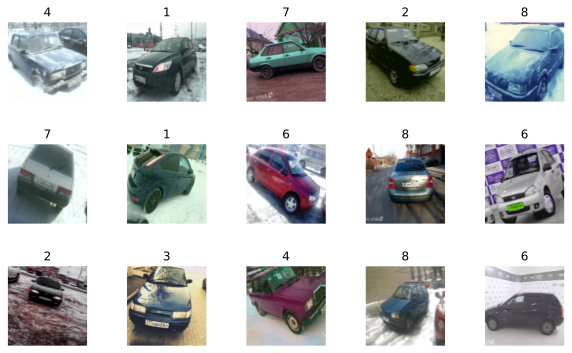

In [16]:
train_datagen.show_data(rows=3, cols=5)

## Строим модель

In [17]:
import os, re, math, random, time, gc, string, pickle, shutil, pathlib, itertools
import numpy as np, pandas as pd, matplotlib.pyplot as plt, PIL

import tensorflow as tf
#import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import *
from tensorflow.keras.activations import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.layers import *
from tensorflow.keras.layers.experimental.preprocessing import *
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.optimizers.schedules import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image
from IPython.display import clear_output
from tqdm.notebook import tqdm

## Используем `EfficientNet`

In [18]:
# строим модель
model = Sequential([
  EfficientNetB0(weights='imagenet', input_shape=input_shape, include_top=False),
  GlobalMaxPool2D(),
  Dropout(0.5),
  Dense(10)
])

model.compile(
    loss=CategoricalCrossentropy(from_logits=True),
    optimizer=Adam(ExponentialDecay(1e-3, 100, 0.9)),
    metrics='accuracy'
)

In [19]:
# обучаем модель
model.fit(train_datagen, validation_data=test_datagen, epochs=5)

Epoch 1/5
1654/1654 [==============================] - 254s 130ms/step - loss: 1.9527 - accuracy: 0.4747 - val_loss: 1.6251 - val_accuracy: 0.4096
Epoch 2/5
1654/1654 [==============================] - 214s 129ms/step - loss: 0.6167 - accuracy: 0.7744 - val_loss: 0.8281 - val_accuracy: 0.7076
Epoch 3/5
1654/1654 [==============================] - 216s 130ms/step - loss: 0.4781 - accuracy: 0.8272 - val_loss: 0.3487 - val_accuracy: 0.8725
Epoch 4/5
1654/1654 [==============================] - 215s 130ms/step - loss: 0.4628 - accuracy: 0.8356 - val_loss: 0.3316 - val_accuracy: 0.8819
Epoch 5/5
1654/1654 [==============================] - 213s 129ms/step - loss: 0.4426 - accuracy: 0.8393 - val_loss: 0.3172 - val_accuracy: 0.8892


Резюмируем:

После 5 эпох обучения
* **Точность на обучающих данных равна 0.83.**

* **Точность на валидационных данных в конце третьей эпохи равна 0.89**.

## Предсказание

In [20]:
test_gen = ImageDataAugmentor(rescale=1./255)
test_sub_generator = test_gen.flow_from_dataframe(dataframe=sample_submission,
                                            directory=sub_path,
                                            x_col="Id",
                                            y_col=None,
                                            shuffle=False,
                                            class_mode=None,
                                            target_size=(IMG_SIZE, IMG_SIZE),
                                            batch_size=BATCH_SIZE)

Found 6675 validated image filenames.


In [21]:
test_sub_generator.reset()
predictions = model.predict(test_sub_generator, 
                                      steps=len(test_sub_generator), 
                                      verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_datagen.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

835/835 [==============================] - 45s 53ms/step


In [22]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, 
                          columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')

submission.to_csv('SUB_2.csv', index=False)

**Точность на Kaggle: 0.897 %**

## Используем `Xception`:

In [28]:
base_model = Xception(weights='imagenet', include_top=False, input_shape = input_shape)

83689472/83683744 [==============================] - 0s 0us/step


In [30]:
#base_model.summary()

In [32]:
# Устанавливаем новую "голову" (head)

x = base_model.output
x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)

# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model_2 = Model(inputs=base_model.input, outputs=predictions)
model_2.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=LR), metrics=["accuracy"])

In [33]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
callbacks_list = [checkpoint]

In [35]:
history = model_2.fit_generator(
        train_datagen,
        steps_per_epoch = len(train_datagen),
        validation_data = test_datagen, 
        validation_steps = len(test_datagen),
        epochs = 3,
        callbacks = callbacks_list
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/3
1654/1654 [==============================] - 321s 194ms/step - loss: 1.9324 - accuracy: 0.2317 - val_loss: 1.8918 - val_accuracy: 0.2868

Epoch 00001: saving model to best_model.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/3
1654/1654 [==============================] - 323s 195ms/step - loss: 1.3820 - accuracy: 0.4327 - val_loss: 1.1180 - val_accuracy: 0.5109

Epoch 00002: saving model to best_model.hdf5
Epoch 3/3
1654/1654 [==============================] - 323s 195ms/step - loss: 1.0373 - accuracy: 0.5791 - val_loss: 0.8172 - val_accuracy: 0.6848

Epoch 00003: saving model to best_model.hdf5


In [38]:
scores = model_2.evaluate_generator(test_datagen, steps=len(test_datagen), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


292/292 [==============================] - 27s 91ms/step - loss: 0.8333 - accuracy: 0.6788
Accuracy: 67.88%


**В итоге точность модели составила: 68%** 

Точность ниже, чем в предыдущей итерации, поэтому оставляем предыдущий сабмит.

# Выводы

* В процессе работы над проектом очень много времени ушло на разбор с директориями -- приходилось переходить из Kaggle Notebooks в коллаб, потому что не получилось подключить Интернет и GPU на платформе.
* Очень много времени ушло на работу с аугментацией данных -- попыталась использовать более продвинутую библиотеку, однако некоторые функции не работали из-за обратной несовместимости версий. Пришлось подбирать нужную версию, чтобы код работал.
* Попробовала построить две модели на аугментированных данных: `EfficientNet` и `Xception`. Первая дала намного лучший результат.
* Остальной более продвинуты функционал не удалось применить из-за отсутствия времени и ресурсов.